In [3]:
import math
import numpy as np
import os
import pandas as pd
import pickle
import random
import json
import matplotlib.pyplot as plt
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.nn.utils import clip_grad_norm_



# !! Change the data_root Import data 
data_root = '/Users/kimli/Desktop/260fp/data_new/'

# each roi's spatial position and GNN embeddings 
with open(os.path.join(data_root, 'development_modified_embeddings.pkl'), 'rb') as file:
    emb_dict = pickle.load(file)


# !! Change the data_root Import each roi's label 
label_df=pd.read_csv("/Users/kimli/Desktop/260fp/data_new/nsclc_roi_labels.csv")



def grab_label(label_df, aq_id, label_name):

    temp_label = label_df.loc[label_df['aq_id']==aq_id][label_name].values[0]
    if math.isnan(temp_label):
        return None
    else:
        return temp_label


def generate_instance_dict(data_dict, label_df, aq_ids=None, split_half=False):

    # instance dict: each entry are the subgraph features and label for one ROI
    # only contains ROIs for which a valid label exists
    instance_dict = {'labels': list(),
                    'aq_ids': list(),
                     'embedbags':list(),
                     'spatialembedbags':list()}

    if aq_ids is None:
        aq_ids = list(data_dict.keys())

    for k in aq_ids:
        # grab label first
        temp_label = grab_label(label_df, k, '2y_survival')


        if temp_label is not None:
            if split_half:
                # split each ROI into two bags (random sampling of subgraphs/instances)
                temp_bagspatial = np.asarray(data_dict[k][0])
                
                temp_bagembed = np.asarray(data_dict[k][1])
                
                n_instances = temp_bagembed.shape[0] # number of subgraphs in the ROI
                idx = np.arange(n_instances)
                # random.shuffle(idx)

                # split the bag and add to dictionary        
                subbagembed_1 = temp_bagembed[idx[:int(n_instances/2)],:]
                subbagspatial_1=temp_bagspatial[idx[:int(n_instances/2)],:]
                instance_dict['embedbags'].append(torch.tensor(np.array(subbagembed_1)).float())
                instance_dict['spatialembedbags'].append(torch.cat([torch.tensor(np.asarray(subbagspatial_1)), torch.tensor(np.asarray(subbagembed_1))], dim=1))
                instance_dict['labels'].append(temp_label)
                instance_dict['aq_ids'].append(k)
                subbagembed_2 = temp_bagembed[idx[int(n_instances/2):],:]
                subbagspatial_2=temp_bagspatial[idx[int(n_instances/2):],:]
                instance_dict['embedbags'].append(torch.tensor(np.array(subbagembed_2)).float())
                instance_dict['spatialembedbags'].append(torch.cat([torch.tensor(np.asarray(subbagspatial_2)), torch.tensor(np.asarray(subbagembed_2))], dim=1))
                instance_dict['labels'].append(temp_label)
                instance_dict['aq_ids'].append(k)

            else:
                instance_dict['labels'].append(temp_label)
                instance_dict['aq_ids'].append(k)
                instance_dict['embedbags'].append(torch.tensor(np.array(data_dict[k][1])).float())
                instance_dict['spatialembedbags'].append(torch.cat([torch.tensor(np.asarray(data_dict[k][0])), torch.tensor(np.asarray(data_dict[k][1]))], dim=1))

    return instance_dict


def getaqids(indices):
  temp=[]
  for i in range(len(indices)):
    temp.append(list(data_dict.keys())[indices[i]])
  return temp


data_dict = emb_dict['embedding_dict']

# Create a list of indices from 0 to 1357 (assuming 0-based indexing) 1358 ROIs
total_samples = len(data_dict.keys())
indices = list(range(total_samples))

all_indices=indices
all_aqids=getaqids(all_indices)
all_instance_dict=generate_instance_dict(data_dict, label_df, aq_ids=all_aqids, split_half=False)

In [4]:
print("Before matching aqids and labels, we have # of data: ",total_samples)
print("After matching aqids and labels, we have # of data: ",len(all_instance_dict["embedbags"]))

Before matching aqids and labels, we have # of data:  1358
After matching aqids and labels, we have # of data:  1011


In [123]:
# Baseline aggregation models with combinations of 4 methods without spatial information

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
from functools import partial
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_curve, precision_recall_curve, auc
from scipy.stats import mode

def extract_summary_stats(all_instance_dict, summary_funcs=[np.mean, np.var, kurtosis]):
    summary_stats = []

    for summary_func in summary_funcs:
        # Calculate the summary statistic for each bag
        bag_stats = [summary_func(np.array(bag), axis=0) for bag in all_instance_dict["embedbags"]]
        # Stack the bag statistics into a 2D array
        summary_stats.append(np.vstack(bag_stats))


    # Concatenate the summary statistics horizontally (axis=1)
    concatenated_stats = np.hstack(summary_stats)

    return concatenated_stats
     


summary_statistics_list = {'mean': [np.mean], 'var': [np.var], 'kurtosis': [kurtosis], 'max':[np.max],
                           'mean_var': [np.mean, np.var], 'mean_kurtosis': [np.mean, kurtosis], 'var_kurtosis': [np.var, kurtosis],'mean_max': [np.mean, np.max], 'max_kurtosis': [np.max, kurtosis], 'var_max': [np.var, np.max],
                           'mean_var_kurtosis': [np.mean, np.var, kurtosis],'mean_var_max': [np.mean, np.var, np.max],'max_var_kurtosis': [np.max, np.var, kurtosis],
                           'mean_var_kurtosis_max': [np.mean, np.var, kurtosis,np.max]}



def get_roc_auc(y_true, y_pred):
    fpr, tpr, _  = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return roc_auc


def get_pr_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    return pr_auc


def get_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred)

df = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=25)

for summary_statistics, stats_func in summary_statistics_list.items():
    roc_auc_list = []
    pr_auc_list = []
    balanced_accuracy_list = []

    for train_index, val_index in skf.split(all_instance_dict["embedbags"], all_instance_dict['labels']):
        X_train_stats = extract_summary_stats(all_instance_dict, stats_func)
        model = LogisticRegression(max_iter=10000).fit(X_train_stats[train_index], np.asarray(all_instance_dict['labels'])[train_index])
        y_val_pred = model.predict(X_train_stats[val_index])
        
        roc_auc = get_roc_auc(np.asarray(all_instance_dict['labels'])[val_index], y_val_pred)
        pr_auc = get_pr_auc(np.asarray(all_instance_dict['labels'])[val_index], y_val_pred)
        balanced_accuracy = balanced_accuracy_score(np.asarray(all_instance_dict['labels'])[val_index], y_val_pred)

        roc_auc_list.append(roc_auc)
        pr_auc_list.append(pr_auc)
        balanced_accuracy_list.append(balanced_accuracy)

    avg_roc_auc = np.mean(roc_auc_list)
    avg_pr_auc = np.mean(pr_auc_list)
    avg_balanced_accuracy = np.mean(balanced_accuracy_list)

    df.append((summary_statistics, avg_roc_auc, avg_pr_auc, avg_balanced_accuracy))

df = pd.DataFrame(df, columns=['Model', 'ROC AUC', 'PR AUC', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)
print(df)


                    Model   ROC AUC    PR AUC  Balanced Accuracy
5           mean_kurtosis  0.657904  0.854504           0.657904
13  mean_var_kurtosis_max  0.655616  0.851086           0.655616
11           mean_var_max  0.654348  0.855885           0.654348
10      mean_var_kurtosis  0.651945  0.851055           0.651945
8            max_kurtosis  0.650457  0.851657           0.650457
0                    mean  0.648520  0.855471           0.648520
7                mean_max  0.648399  0.853581           0.648399
4                mean_var  0.644821  0.854288           0.644821
12       max_var_kurtosis  0.640871  0.847920           0.640871
3                     max  0.628448  0.846521           0.628448
9                 var_max  0.624014  0.845140           0.624014
2                kurtosis  0.579759  0.831571           0.579759
6            var_kurtosis  0.579699  0.830369           0.579699
1                     var  0.527173  0.834931           0.527173


In [122]:
# Baseline aggregation models with combinations of 4 methods without spatial information

def extract_summary_stats(all_instance_dict, summary_funcs=[np.mean, np.var, kurtosis]):
    summary_stats = []

    for summary_func in summary_funcs:
        # Calculate the summary statistic for each bag
        bag_stats = [summary_func(np.array(bag), axis=0) for bag in all_instance_dict["spatialembedbags"]]
        # Stack the bag statistics into a 2D array
        summary_stats.append(np.vstack(bag_stats))


    # Concatenate the summary statistics horizontally (axis=1)
    concatenated_stats = np.hstack(summary_stats)

    return concatenated_stats

df = []
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=25)

for summary_statistics, stats_func in summary_statistics_list.items():
    roc_auc_list = []
    pr_auc_list = []
    balanced_accuracy_list = []

    for train_index, val_index in skf.split(all_instance_dict["spatialembedbags"], all_instance_dict['labels']):
        X_train_stats = extract_summary_stats(all_instance_dict, stats_func)
        model = LogisticRegression(max_iter=10000).fit(X_train_stats[train_index], np.asarray(all_instance_dict['labels'])[train_index])
        y_val_pred = model.predict(X_train_stats[val_index])
        
        roc_auc = get_roc_auc(np.asarray(all_instance_dict['labels'])[val_index], y_val_pred)
        pr_auc = get_pr_auc(np.asarray(all_instance_dict['labels'])[val_index], y_val_pred)
        balanced_accuracy = balanced_accuracy_score(np.asarray(all_instance_dict['labels'])[val_index], y_val_pred)

        roc_auc_list.append(roc_auc)
        pr_auc_list.append(pr_auc)
        balanced_accuracy_list.append(balanced_accuracy)

    avg_roc_auc = np.mean(roc_auc_list)
    avg_pr_auc = np.mean(pr_auc_list)
    avg_balanced_accuracy = np.mean(balanced_accuracy_list)

    df.append((summary_statistics, avg_roc_auc, avg_pr_auc, avg_balanced_accuracy))

df = pd.DataFrame(df, columns=['Model', 'ROC AUC', 'PR AUC', 'Balanced Accuracy']).sort_values("Balanced Accuracy", ascending=False)
print(df)


                    Model   ROC AUC    PR AUC  Balanced Accuracy
7                mean_max  0.657251  0.856576           0.657251
5           mean_kurtosis  0.654182  0.852794           0.654182
8            max_kurtosis  0.638702  0.847679           0.638702
0                    mean  0.635180  0.850848           0.635180
3                     max  0.621853  0.845194           0.621853
2                kurtosis  0.577539  0.829842           0.577539
4                mean_var  0.576927  0.834054           0.576927
13  mean_var_kurtosis_max  0.560011  0.830495           0.560011
1                     var  0.559438  0.835984           0.559438
6            var_kurtosis  0.559438  0.835984           0.559438
10      mean_var_kurtosis  0.558602  0.832263           0.558602
11           mean_var_max  0.558562  0.830979           0.558562
9                 var_max  0.557818  0.830527           0.557818
12       max_var_kurtosis  0.557818  0.830527           0.557818


In [6]:
class CustomDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = np.asarray(samples,dtype=object)
        self.labels = np.asarray(labels,dtype=object)


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]



# Build Custom Dataset
dataset=CustomDataset(all_instance_dict['spatialembedbags'], all_instance_dict['labels'])


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/2766423123.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  self.samples = np.asarray(samples,dtype=object)


In [111]:
#-----------------------------------------------------------------------------
# hyperparameters

batch_size = 24 
epoch = 45
lr = 5e-4
k_folds=3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_embd = 32
n_head = 2                  # has to be the 32%n_head=0
n_layer = 1                 
#-----------------------------------------------------------------------------

In [112]:
#Model1: Multi-attention

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.Wk = nn.Linear(n_embd, head_size, bias=False)
        self.Wq = nn.Linear(n_embd, head_size, bias=False)
        self.Wv = nn.Linear(n_embd, head_size, bias=False)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B, T, C = x.shape
        k = self.Wk(x)  # (B,T,hs)
        q = self.Wq(x)  # (B,T,hs)
        # compute attention weights
        alpha = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5  # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        alpha = F.softmax(alpha, dim=-1)  # (B, T, T)
        # perform the weighted aggregation of the values
        v = self.Wv(x)  # (B,T,hs)
        out = alpha @ v  # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out


class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return out


class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension =32, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class TissueGPT(nn.Module):

    def __init__(self):
        super().__init__()
        # Project the 2 dimension spatial feature to 32 dimension
        self.embedspatial=nn.Sequential(
        nn.Linear(2, 32),
        nn.LayerNorm(32),
        nn.Tanh()
        )
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)  # final layer norm
        self.lm_head = nn.Linear(n_embd, 1)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, targets=None):

        B = x.size()[0]
        T = x.size()[1]

        #!!!!! Without spatial information, n_embed =32 (need to change in hyperparameter)
        x=x[:,:,2:]

         #!!!!! With concatenated spatial information, n_embed =34 (need to change in hyperparameter)
        # x = x

        #!!!!! With embedded Spatial information, n_embed =32 (need to change in hyperparameter)
        # x= self.embedspatial(x[:,:,:2])+x[:,:,2:]

        
        
        x = self.blocks(x)  # (B,T,C)
        x = self.ln_f(x)  # (B,T,C)
        x = torch.sum(x, dim=1, keepdim=True)  # (B,1,C)
        output = self.lm_head(x)  # (B,1,1)

        B, T, C = output.shape
        output = output.view(B, T * C)
        

        return output



In [113]:
# Model2: Simple attention module (customized from https://github.com/AMLab-Amsterdam/AttentionDeepMIL/blob/master/model.py)

class Attention(nn.Module):
    def __init__(self,L):
        
        super(Attention, self).__init__()
        self.embedspatial=nn.Sequential(
        nn.Linear(2, 32),
        nn.LayerNorm(32),
        nn.Tanh()
        )
        
        self.L = L # number of input features
        self.D = int(self.L/4) # dimension for attention module
        self.K = 1 # aggregated dimension (number of "instances" after attention) - output of attention module KxL

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        '''self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, 1),
            nn.Linear(self.L*self.K, 1)
            nn.Sigmoid()
        )'''
        
        if self.L > 256:
            self.classifier = nn.Sequential(
                    nn.Linear(self.L*self.K, self.L),
                    nn.LeakyReLU(),
                    nn.Linear(self.L, self.L),
                    nn.LeakyReLU(),
                    nn.Linear(self.L, 1)
            )
        
        else: 
            '''self.classifier = nn.Sequential(
                    nn.Linear(self.L*self.K, self.L),
                    nn.LeakyReLU(),
                    nn.Linear(self.L, 1))'''
            self.classifier = nn.Linear(self.L, 1)

    def forward(self, H):
        # H: BxNxL
        B = H.size()[0]
        N = H.size()[1]



        #!! Without spatial information, n_embed =32 (Need to change in hyperparameter)
        H=H[:,:,2:]

        #!! With concatenated spatial information, n_embed =34 (Need to change in hyperparameter)
        # H = H

        #!! With embedded Spatial information, n_embed =32 (Need to change in hyperparameter)
        # H= self.embedspatial(H[:,:,:2])+H[:,:,2:]



        
        
        # Pay attention to keep the output as BxNx1
        A = self.attention(H).transpose(-1, -2) # Bx1xN (weights for each instance)
        # generate an attention mechanism that doesn't do anything (compute the mean)
        # A = torch.ones((B,1,N)).to(H.device) # .to(device)
        A = torch.softmax(A, dim=2) # normalize along N (instance weights sum up to 1)

        # multiply H with A (apply attention)
        # transpose H from BxNxL to BxLxN for proper multiplication
        M = A * H.transpose(1, 2) # BxLxN (weighted along N)

        # sum over N dimension
        M = torch.sum(M, dim=2, keepdim=True) # BxLx1

        # Now, to match the classifier input shape, we reshape M from BxLx1 to Bx1xL
        M = M.transpose(1, 2) # Bx1xL

        Y_prob = self.classifier(M.view(M.size(0), -1))
        # Y_hat = torch.ge(Y_prob, 0.5).float()
        

        return Y_prob

In [114]:
# Set seeds to duplicate the result
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(25)


def collate_fn(batch):
    
    # Get the samples and labels from the batch
    samples, labels = zip(*batch)

    # Convert the list of numpy arrays to a numpy array 
    samples = np.asarray(samples,dtype=object)
    
    max_length = max(sample.shape[0] for sample in samples)

    padded_samples = [
        np.pad(updated_sample, ((0, max_length - updated_sample.shape[0]), (0, 0)), mode='constant')
        for updated_sample in samples
    ]

    # Convert the samples and labels to PyTorch tensors
    return torch.tensor(padded_samples, dtype=torch.float32), torch.tensor(labels)


def train_model(learning_rate=lr, num_epochs=20, device='cuda:0',dovalidation=False,k_folds=3):
    
    
    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=k_folds, shuffle=True)
    print(k_folds)
    
    # For fold results
    foldresults = list()
    training_losses = list()
    training_auroc = list()
    validation_auroc = list()

    bestval_auc=0
    
    # K-fold Cross Validation model evaluation
    for fold, (train_ids, vali_ids) in enumerate(kfold.split(dataset)):

        learning_rate=lr
        # Print
        print('--------------------------------')
        print(f'FOLD {fold}')
        print('--------------------------------')



        # oversample class 0 (with weight: ratio(see above))
        # Compute weights

        ratio = np.sum(np.asarray(dataset.labels[train_ids])) / (len(train_ids) - np.sum(np.asarray(dataset.labels[train_ids])))
        print("The class 0 vs 1 ratio: ",ratio)


        class_weights = np.asarray([ratio, 1])
    
        trainsampler = WeightedRandomSampler(weights=np.asarray([class_weights[int(dataset.labels[l])] for l in train_ids]),
                                            num_samples=len(train_ids),
                                            replacement=True)
        valisampler = torch.utils.data.SubsetRandomSampler(vali_ids)

            
        training_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, sampler=trainsampler, collate_fn=collate_fn)
        validation_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=valisampler, collate_fn=collate_fn)

                 
        
        # Check if the specified device is available and switch to it
        device = torch.device(device if torch.cuda.is_available() else 'cpu')
    
        # Initialize model1 and move it to the device
        model = TissueGPT().to(device)

        # Initalize model2 and move it to the device
        # model = Attention(L=32).to(device)
        

        # Define the loss function 
        criterion = nn.BCEWithLogitsLoss()
    
        # Define the optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
    
        model.train()  # Ensure the model is in training mode
    
                
        t_auc = 0
        for epoch in range(num_epochs):
            running_loss = 0.0
            all_labels = []
            all_predictions = []
    
            if (epoch >= 1)&(t_auc>.65):
                learning_rate = learning_rate/2
                for g in optimizer.param_groups:
                        g['lr'] = learning_rate
    
            for batch in training_dataloader:
                # Assuming each batch in the dataloader is a tuple of (inputs, targets)
                inputs, targets = batch
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
    
                # Move inputs and targets to the device
                inputs = inputs.to(device)
                targets = targets.to(device).unsqueeze(1)
    
                # Clear the gradients
                optimizer.zero_grad()
    
                # Forward propagation
                outputs = model(inputs)

                # print("Training output",outputs)
    
                # Calculate the loss (before sigmoid so the loss is big)
                loss = criterion(outputs, targets)

                # print("training loss",loss)
    
                # Backward propagation
                loss.backward()

                # Clip gradients to a maximum norm of 1.0
                max_norm = 1.0
                clip_grad_norm_(model.parameters(), max_norm)
    
                # Update the weights
                optimizer.step()
    
                # Update the running loss
                running_loss += loss.item() * inputs.size(0)
                all_labels.extend(targets.detach().cpu().numpy())
                # sigmoid the outputs to make it between 0 and 1
                all_predictions.extend(torch.sigmoid(outputs).detach().cpu().numpy())
    
    
            # Calculate the average loss over the epoch
            epoch_loss = running_loss / len(training_dataloader.dataset)
    
            t_auc = roc_auc_score(all_labels, all_predictions)
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, AUROC {t_auc:.4f}')
            # compute training AUROC for tracking purposes
    
            training_losses.append(epoch_loss)
            training_auroc.append(t_auc)

            

            
            if dovalidation is True:
                # evaluation step (every other epoch)
                print('performing validation step')
                if epoch%1 == 0:
                    model.eval()
                    all_labels = []
                    all_predictions = []
    
                    for batch in validation_dataloader:
                        # Assuming each batch in the dataloader is a tuple of (inputs, targets)
                        inputs, targets = batch
    
                        inputs = inputs.to(torch.float32)
                        targets = targets.to(torch.float32)
    
                        # Move inputs and targets to the device
                        inputs = inputs.to(device)
                        targets = targets.to(device).unsqueeze(1)
    
                        # Forward propagation
                        outputs = model(inputs)
                        
    
                        # Update the save outputs and targets
                        all_labels.extend(targets.detach().cpu().numpy())
                        all_predictions.extend(torch.sigmoid(outputs).detach().cpu().numpy())

                        # print("vali:all_predictions", all_predictions)
                        # print("vali:all_labels", all_labels)
                    
                    auc = roc_auc_score(all_labels, all_predictions)
                    print(f'val AUROC {auc:.4f}')
                    validation_auroc.append(auc)
                    model.train()
            
            print('lr', optimizer.param_groups[0]['lr'])
        foldresults.append(auc)
            
            # Saving the model
            # if auc>bestval_auc:
            #     bestval_auc=auc
            #     save_path = f'./model-fold-{fold}.pth'
            #     torch.save(model.state_dict(), save_path)

    
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    sum_results = 0

    for i in range(len(foldresults)):
        print(f'Fold {i}: {foldresults[i]} ')
        sum_results += foldresults[i]
    
    average = sum_results / len(foldresults)
    print(f'Average: {average}')


    
    return model, training_losses, training_auroc, validation_auroc,foldresults


model, training_loss, training_auroc, validation_auroc,foldresults = train_model(learning_rate=lr,
                                                                     num_epochs=epoch,
                                                                     device='cuda:0',
                                                                     dovalidation=True,
                                                                     k_folds=k_folds
                                                                     )


3
--------------------------------
FOLD 0
--------------------------------
The class 0 vs 1 ratio:  1.9051724137931034


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 1/45, Loss: 0.5146, AUROC 0.3760
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.3001
lr 0.0005


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 2/45, Loss: 0.5089, AUROC 0.3341
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.2935
lr 0.0005


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 3/45, Loss: 0.4948, AUROC 0.3408
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.2899
lr 0.0005


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 4/45, Loss: 0.4837, AUROC 0.3131
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.3079
lr 0.0005


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 5/45, Loss: 0.4757, AUROC 0.3348
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.3697
lr 0.0005


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 6/45, Loss: 0.4692, AUROC 0.4600
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.4785
lr 0.0005


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 7/45, Loss: 0.4651, AUROC 0.5144
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.5809
lr 0.0005


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 8/45, Loss: 0.4603, AUROC 0.5807
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.6464
lr 0.0005


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 9/45, Loss: 0.4541, AUROC 0.6170
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.6848
lr 0.0005


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 10/45, Loss: 0.4482, AUROC 0.6678
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.6990
lr 0.0005


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 11/45, Loss: 0.4448, AUROC 0.6790
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.6965
lr 0.00025


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 12/45, Loss: 0.4407, AUROC 0.6598
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.6852
lr 0.000125


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 13/45, Loss: 0.4406, AUROC 0.6764
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.6907
lr 6.25e-05


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 14/45, Loss: 0.4416, AUROC 0.6680
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7023
lr 3.125e-05


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 15/45, Loss: 0.4403, AUROC 0.6762
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.6958
lr 1.5625e-05


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 16/45, Loss: 0.4435, AUROC 0.6557
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7132
lr 7.8125e-06


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 17/45, Loss: 0.4425, AUROC 0.6490
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.6911
lr 3.90625e-06


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 18/45, Loss: 0.4426, AUROC 0.6645
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7127
lr 3.90625e-06


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 19/45, Loss: 0.4366, AUROC 0.6932
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.6965
lr 1.953125e-06


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 20/45, Loss: 0.4403, AUROC 0.6437
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7108
lr 9.765625e-07


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 21/45, Loss: 0.4390, AUROC 0.6816
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7181
lr 9.765625e-07


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 22/45, Loss: 0.4424, AUROC 0.6664
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7048
lr 4.8828125e-07


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 23/45, Loss: 0.4426, AUROC 0.6308
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7112
lr 2.44140625e-07


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 24/45, Loss: 0.4385, AUROC 0.6993
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.6982
lr 2.44140625e-07


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 25/45, Loss: 0.4400, AUROC 0.6932
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7215
lr 1.220703125e-07


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 26/45, Loss: 0.4447, AUROC 0.6453
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.6948
lr 6.103515625e-08


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 27/45, Loss: 0.4408, AUROC 0.6506
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7031
lr 6.103515625e-08


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 28/45, Loss: 0.4456, AUROC 0.6180
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.6991
lr 3.0517578125e-08


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 29/45, Loss: 0.4405, AUROC 0.6399
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.6942
lr 3.0517578125e-08


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 30/45, Loss: 0.4390, AUROC 0.6747
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7045
lr 3.0517578125e-08


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 31/45, Loss: 0.4350, AUROC 0.6915
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7176
lr 1.52587890625e-08


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 32/45, Loss: 0.4386, AUROC 0.7058
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7027
lr 7.62939453125e-09


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 33/45, Loss: 0.4388, AUROC 0.7088
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7082
lr 3.814697265625e-09


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 34/45, Loss: 0.4413, AUROC 0.6467
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.6942
lr 1.9073486328125e-09


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 35/45, Loss: 0.4384, AUROC 0.6764
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7117
lr 1.9073486328125e-09


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 36/45, Loss: 0.4397, AUROC 0.7186
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7080
lr 9.5367431640625e-10


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 37/45, Loss: 0.4392, AUROC 0.6870
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7093
lr 4.76837158203125e-10


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 38/45, Loss: 0.4420, AUROC 0.6378
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7057
lr 2.384185791015625e-10


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 39/45, Loss: 0.4392, AUROC 0.6551
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7050
lr 2.384185791015625e-10


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 40/45, Loss: 0.4421, AUROC 0.6574
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7007
lr 1.1920928955078125e-10


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 41/45, Loss: 0.4402, AUROC 0.6444
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.6987
lr 5.960464477539063e-11


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 42/45, Loss: 0.4389, AUROC 0.6664
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.6992
lr 5.960464477539063e-11


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 43/45, Loss: 0.4386, AUROC 0.6761
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7104
lr 2.980232238769531e-11


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 44/45, Loss: 0.4410, AUROC 0.7159
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7102
lr 1.4901161193847657e-11


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 45/45, Loss: 0.4410, AUROC 0.6615
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7123
lr 7.450580596923828e-12
--------------------------------
FOLD 1
--------------------------------
The class 0 vs 1 ratio:  2.0636363636363635


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 1/45, Loss: 0.4371, AUROC 0.7434
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7245
lr 0.0005


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 2/45, Loss: 0.4320, AUROC 0.7773
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7164
lr 0.00025


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 3/45, Loss: 0.4358, AUROC 0.7167
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7159
lr 0.000125


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 4/45, Loss: 0.4365, AUROC 0.7435
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7154
lr 6.25e-05


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 5/45, Loss: 0.4322, AUROC 0.7771
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7153
lr 3.125e-05


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 6/45, Loss: 0.4275, AUROC 0.7540
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7161
lr 1.5625e-05


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 7/45, Loss: 0.4283, AUROC 0.7849
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7174
lr 7.8125e-06


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 8/45, Loss: 0.4315, AUROC 0.7372
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7132
lr 3.90625e-06


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 9/45, Loss: 0.4283, AUROC 0.7231
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7134
lr 1.953125e-06


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 10/45, Loss: 0.4368, AUROC 0.7034
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7139
lr 9.765625e-07


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 11/45, Loss: 0.4349, AUROC 0.7432
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7111
lr 4.8828125e-07


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 12/45, Loss: 0.4326, AUROC 0.7445
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7129
lr 2.44140625e-07


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 13/45, Loss: 0.4358, AUROC 0.7157
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7113
lr 1.220703125e-07


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 14/45, Loss: 0.4303, AUROC 0.6874
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7139
lr 6.103515625e-08


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 15/45, Loss: 0.4344, AUROC 0.7093
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7111
lr 3.0517578125e-08


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 16/45, Loss: 0.4337, AUROC 0.7379
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7182
lr 1.52587890625e-08


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 17/45, Loss: 0.4341, AUROC 0.7179
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7143
lr 7.62939453125e-09


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 18/45, Loss: 0.4339, AUROC 0.6922
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7149
lr 3.814697265625e-09


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 19/45, Loss: 0.4267, AUROC 0.7034
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7102
lr 1.9073486328125e-09


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 20/45, Loss: 0.4319, AUROC 0.7355
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7090
lr 9.5367431640625e-10


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 21/45, Loss: 0.4305, AUROC 0.7407
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7126
lr 4.76837158203125e-10


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 22/45, Loss: 0.4328, AUROC 0.7175
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7162
lr 2.384185791015625e-10


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 23/45, Loss: 0.4354, AUROC 0.7309
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7107
lr 1.1920928955078125e-10


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 24/45, Loss: 0.4357, AUROC 0.7243
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7136
lr 5.960464477539063e-11


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 25/45, Loss: 0.4363, AUROC 0.7219
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7120
lr 2.980232238769531e-11


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 26/45, Loss: 0.4308, AUROC 0.7455
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7129
lr 1.4901161193847657e-11


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 27/45, Loss: 0.4356, AUROC 0.6898
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7146
lr 7.450580596923828e-12


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 28/45, Loss: 0.4316, AUROC 0.7197
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7138
lr 3.725290298461914e-12


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 29/45, Loss: 0.4311, AUROC 0.7168
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7102
lr 1.862645149230957e-12


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 30/45, Loss: 0.4337, AUROC 0.7120
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7137
lr 9.313225746154785e-13


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 31/45, Loss: 0.4327, AUROC 0.7220
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7132
lr 4.656612873077393e-13


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 32/45, Loss: 0.4316, AUROC 0.7299
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7116
lr 2.3283064365386963e-13


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 33/45, Loss: 0.4343, AUROC 0.7551
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7134
lr 1.1641532182693482e-13


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 34/45, Loss: 0.4295, AUROC 0.7498
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7101
lr 5.820766091346741e-14


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 35/45, Loss: 0.4299, AUROC 0.7534
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7135
lr 2.9103830456733704e-14


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 36/45, Loss: 0.4319, AUROC 0.7359
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7088
lr 1.4551915228366852e-14


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 37/45, Loss: 0.4294, AUROC 0.7294
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7124
lr 7.275957614183426e-15


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 38/45, Loss: 0.4261, AUROC 0.7182
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7104
lr 3.637978807091713e-15


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 39/45, Loss: 0.4297, AUROC 0.7096
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7076
lr 1.8189894035458565e-15


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 40/45, Loss: 0.4346, AUROC 0.7504
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7127
lr 9.094947017729283e-16


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 41/45, Loss: 0.4226, AUROC 0.7258
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7106
lr 4.547473508864641e-16


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 42/45, Loss: 0.4364, AUROC 0.7246
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7140
lr 2.2737367544323206e-16


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 43/45, Loss: 0.4271, AUROC 0.7363
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7154
lr 1.1368683772161603e-16


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 44/45, Loss: 0.4296, AUROC 0.7084
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7113
lr 5.684341886080802e-17


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 45/45, Loss: 0.4298, AUROC 0.7280
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7166
lr 2.842170943040401e-17
--------------------------------
FOLD 2
--------------------------------
The class 0 vs 1 ratio:  1.9823008849557522


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 1/45, Loss: 0.4507, AUROC 0.6462
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7278
lr 0.0005


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 2/45, Loss: 0.4438, AUROC 0.6567
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7362
lr 0.0005


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 3/45, Loss: 0.4365, AUROC 0.6818
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7245
lr 0.00025


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 4/45, Loss: 0.4378, AUROC 0.6175
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7212
lr 0.000125


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 5/45, Loss: 0.4306, AUROC 0.6980
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7155
lr 0.000125


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 6/45, Loss: 0.4300, AUROC 0.6503
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7293
lr 6.25e-05


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 7/45, Loss: 0.4362, AUROC 0.6458
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7252
lr 3.125e-05


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 8/45, Loss: 0.4426, AUROC 0.6252
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7227
lr 3.125e-05


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 9/45, Loss: 0.4366, AUROC 0.6526
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7272
lr 3.125e-05


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 10/45, Loss: 0.4277, AUROC 0.6863
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7194
lr 1.5625e-05


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 11/45, Loss: 0.4247, AUROC 0.6825
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7193
lr 7.8125e-06


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 12/45, Loss: 0.4306, AUROC 0.6642
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7273
lr 3.90625e-06


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 13/45, Loss: 0.4283, AUROC 0.6771
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7165
lr 1.953125e-06


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 14/45, Loss: 0.4318, AUROC 0.6365
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7261
lr 9.765625e-07


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 15/45, Loss: 0.4283, AUROC 0.6983
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7302
lr 9.765625e-07


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 16/45, Loss: 0.4282, AUROC 0.7123
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7306
lr 4.8828125e-07


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 17/45, Loss: 0.4231, AUROC 0.6976
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7131
lr 2.44140625e-07


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 18/45, Loss: 0.4257, AUROC 0.6806
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7344
lr 1.220703125e-07


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 19/45, Loss: 0.4302, AUROC 0.6801
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7199
lr 6.103515625e-08


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 20/45, Loss: 0.4299, AUROC 0.6350
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7333
lr 3.0517578125e-08


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 21/45, Loss: 0.4320, AUROC 0.6135
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7268
lr 3.0517578125e-08


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 22/45, Loss: 0.4385, AUROC 0.6783
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7253
lr 3.0517578125e-08


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 23/45, Loss: 0.4337, AUROC 0.6507
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7185
lr 1.52587890625e-08


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 24/45, Loss: 0.4335, AUROC 0.6161
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7301
lr 7.62939453125e-09


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 25/45, Loss: 0.4325, AUROC 0.6568
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7205
lr 7.62939453125e-09


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 26/45, Loss: 0.4338, AUROC 0.6365
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7265
lr 3.814697265625e-09


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 27/45, Loss: 0.4294, AUROC 0.6572
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7229
lr 3.814697265625e-09


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 28/45, Loss: 0.4345, AUROC 0.5991
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7282
lr 1.9073486328125e-09


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 29/45, Loss: 0.4302, AUROC 0.6794
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7265
lr 1.9073486328125e-09


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 30/45, Loss: 0.4296, AUROC 0.6588
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7179
lr 9.5367431640625e-10


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 31/45, Loss: 0.4270, AUROC 0.6771
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7260
lr 4.76837158203125e-10


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 32/45, Loss: 0.4230, AUROC 0.6978
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7176
lr 2.384185791015625e-10


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 33/45, Loss: 0.4342, AUROC 0.6116
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7306
lr 1.1920928955078125e-10


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 34/45, Loss: 0.4313, AUROC 0.6718
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7228
lr 1.1920928955078125e-10


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 35/45, Loss: 0.4330, AUROC 0.6481
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7216
lr 5.960464477539063e-11


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 36/45, Loss: 0.4268, AUROC 0.6902
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7224
lr 5.960464477539063e-11


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 37/45, Loss: 0.4352, AUROC 0.6413
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7359
lr 2.980232238769531e-11


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 38/45, Loss: 0.4302, AUROC 0.6456
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7335
lr 2.980232238769531e-11


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 39/45, Loss: 0.4259, AUROC 0.6660
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7298
lr 2.980232238769531e-11


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 40/45, Loss: 0.4307, AUROC 0.6612
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7360
lr 1.4901161193847657e-11


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 41/45, Loss: 0.4334, AUROC 0.6566
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7203
lr 7.450580596923828e-12


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 42/45, Loss: 0.4229, AUROC 0.6779
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7241
lr 3.725290298461914e-12


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 43/45, Loss: 0.4312, AUROC 0.6727
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7318
lr 1.862645149230957e-12


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 44/45, Loss: 0.4286, AUROC 0.6571
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7261
lr 9.313225746154785e-13


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


Epoch 45/45, Loss: 0.4291, AUROC 0.6726
performing validation step


/var/folders/ky/qxf0hz3x55q7bb7nn36_nf640000gn/T/ipykernel_10348/850399617.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(samples,dtype=object)


val AUROC 0.7303
lr 4.656612873077393e-13
K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS
--------------------------------
Fold 0: 0.7122714343762697 
Fold 1: 0.7165600185028139 
Fold 2: 0.730325537294564 
Average: 0.7197189967245493


Text(0.5, 1.0, '1st Fold AUROC - Epoch')

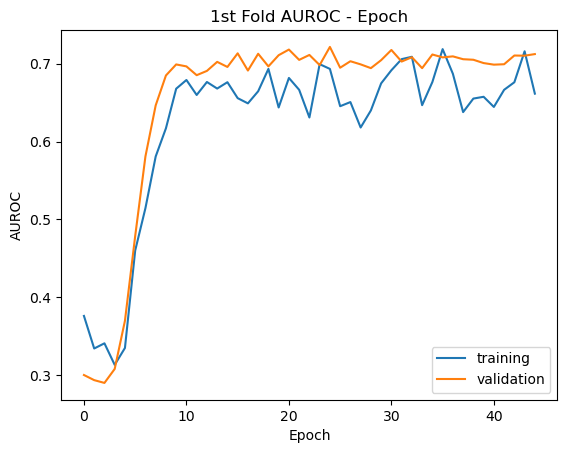

In [115]:
import matplotlib.pyplot as plt

plt.plot(training_auroc[0:epoch], label='training')
plt.plot(validation_auroc[0:epoch], label='validation')
plt.ylabel('AUROC')
plt.xlabel('Epoch')
plt.legend()
plt.title("1st Fold AUROC - Epoch")

Text(0.5, 1.0, '2nd Fold AUROC - Epoch')

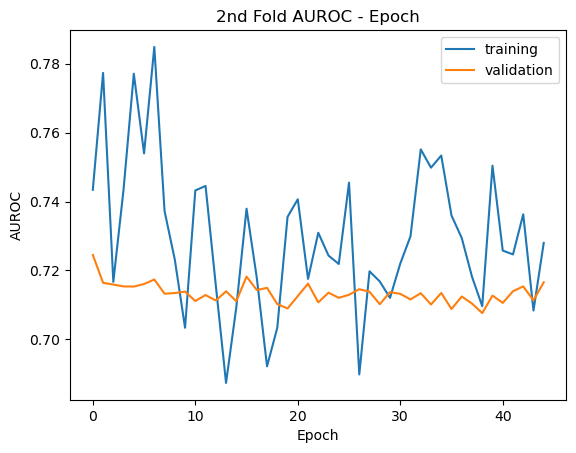

In [116]:
plt.plot(training_auroc[epoch:2*epoch], label='training')
plt.plot(validation_auroc[epoch:2*epoch], label='validation')
plt.ylabel('AUROC')
plt.xlabel('Epoch')
plt.legend()
plt.title("2nd Fold AUROC - Epoch")

Text(0.5, 1.0, '3rd Fold AUROC - Epoch')

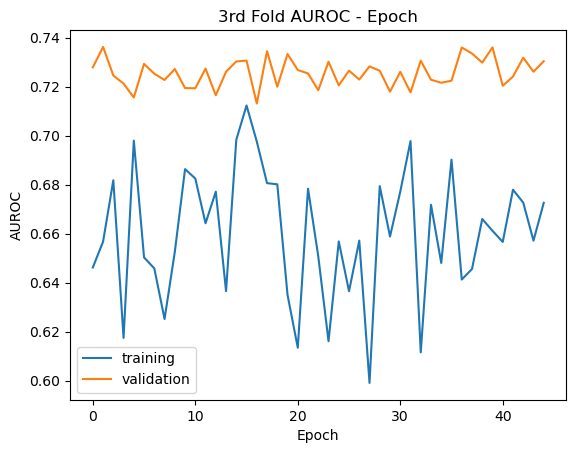

In [117]:
plt.plot(training_auroc[2*epoch:3*epoch], label='training')
plt.plot(validation_auroc[2*epoch:3*epoch], label='validation')
plt.ylabel('AUROC')
plt.xlabel('Epoch')
plt.legend()
plt.title("3rd Fold AUROC - Epoch")

Text(0.5, 1.0, '1st Fold training loss')

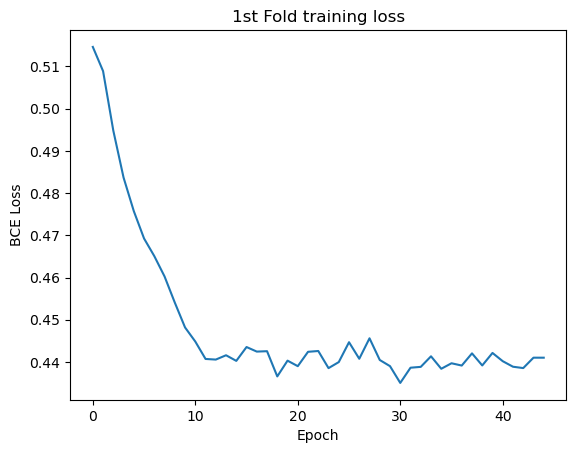

In [118]:
plt.plot(training_loss[0:epoch])
plt.ylabel('BCE Loss')
plt.xlabel('Epoch')
plt.title("1st Fold training loss")

Text(0.5, 1.0, '2nd Fold training loss')

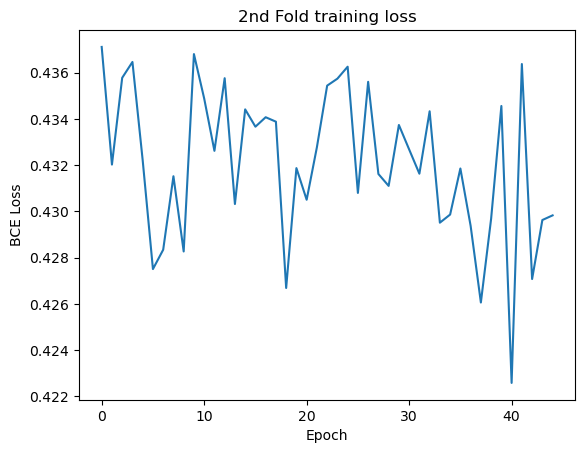

In [119]:
plt.plot(training_loss[epoch:2*epoch])
plt.ylabel('BCE Loss')
plt.xlabel('Epoch')
plt.title("2nd Fold training loss")

Text(0.5, 1.0, '3rd Fold training loss')

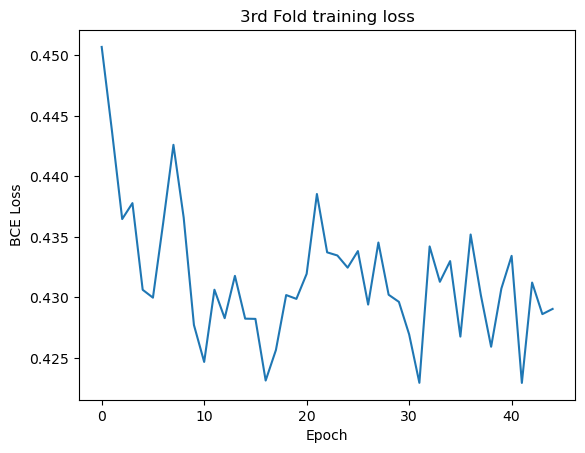

In [120]:
plt.plot(training_loss[2*epoch:3*epoch])
plt.ylabel('BCE Loss')
plt.xlabel('Epoch')
plt.title("3rd Fold training loss")

Text(0.5, 1.0, '3 Folds last epoch validation AUROC')

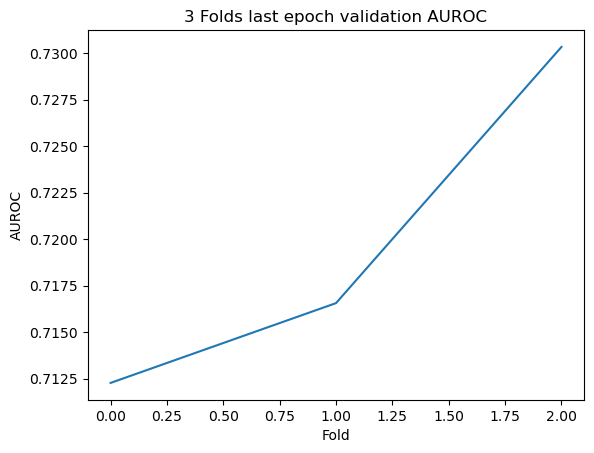

In [121]:
plt.plot(foldresults)
plt.ylabel('AUROC')
plt.xlabel('Fold')
plt.title("3 Folds last epoch validation AUROC")